In [3]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

datapath = '/content/drive/MyDrive/NLP/singapore_airlines_reviews.csv'

df = pd.read_csv(datapath)
print(df.head())
df.dropna(subset=['text', 'rating'], inplace=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


              published_date published_platform  rating    type  \
0  2024-03-12T14:41:14-04:00            Desktop       3  review   
1  2024-03-11T19:39:13-04:00            Desktop       5  review   
2  2024-03-11T12:20:23-04:00            Desktop       1  review   
3  2024-03-11T07:12:27-04:00            Desktop       5  review   
4  2024-03-10T05:34:18-04:00            Desktop       2  review   

                                                text  \
0  We used this airline to go from Singapore to L...   
1  The service on Singapore Airlines Suites Class...   
2  Booked, paid and received email confirmation f...   
3  Best airline in the world, seats, food, servic...   
4  Premium Economy Seating on Singapore Airlines ...   

                                               title  helpful_votes  
0                                                 Ok              0  
1  The service in Suites Class makes one feel lik...              0  
2                         Don’t give them your mon

In [5]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')
df['title'] = df['title'].astype(str).apply(preprocess_text)
df['cleaned_text'] = df['text'].apply(preprocess_text)
df['cleaned_title'] = df['title'].apply(preprocess_text)

In [6]:
glove_path = '/content/drive/MyDrive/NLP/glove.6B.100d.txt'  # Path to your GloVe file
glove_model = {}
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_model[word] = vector

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

df['combined_text'] = df['cleaned_text'] + " " + df['cleaned_title']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['combined_text'])
word_index = tokenizer.word_index

def prepare_text(df, column, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(df[column])
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.initializers import Constant
import numpy as np

max_length_text = 100
max_length_title = 20
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix = embedding_matrix.astype(np.float32)

print("Type of embedding_matrix:", type(embedding_matrix))
print("Shape of embedding_matrix:", embedding_matrix.shape)
print("Dtype of embedding_matrix:", embedding_matrix.dtype)
print("Type of word_index:", type(word_index))
print("Length of word_index:", len(word_index))
print("Input dimensions:", len(word_index) + 1, embedding_dim)

assert embedding_matrix.shape == (len(word_index) + 1, embedding_dim), "Embedding matrix shape is incorrect."

assert embedding_matrix.dtype == np.float32, "Embedding matrix dtype is incorrect."

text_input = Input(shape=(max_length_text,), name='text_input')
title_input = Input(shape=(max_length_title,), name='title_input')

try:
    embedding_layer_text = Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False
    )
    embedding_layer_title = Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False
    )
    print("Embedding layers created successfully.")
except ValueError as e:
    print("Error creating embedding layer:", e)

Type of embedding_matrix: <class 'numpy.ndarray'>
Shape of embedding_matrix: (17590, 100)
Dtype of embedding_matrix: float32
Type of word_index: <class 'dict'>
Length of word_index: 17589
Input dimensions: 17590 100
Embedding layers created successfully.


In [10]:
# Embed the inputs
text_embedding = embedding_layer_text(text_input)
title_embedding = embedding_layer_title(title_input)

# Define LSTM layers
text_lstm = LSTM(100)(text_embedding)
title_lstm = LSTM(100)(title_embedding)

# Concatenate the LSTM outputs
concat = Concatenate()([text_lstm, title_lstm])

# Add a dense layer and output layer
dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='linear')(dense)  # Assuming regression for ratings

# Create the model
model = Model(inputs=[text_input, title_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 title_input (InputLayer)    [(None, 20)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             1759000   ['text_input[0][0]']          
                                                                                                  
 embedding_1 (Embedding)     (None, 20, 100)              1759000   ['title_input[0][0]']         
                                                                                            

In [11]:
# Prepare sequences for text and title
text_sequences = prepare_text(df, 'cleaned_text', tokenizer, max_length_text)
title_sequences = prepare_text(df, 'cleaned_title', tokenizer, max_length_title)

history = model.fit({'text_input': text_sequences, 'title_input': title_sequences}, df['rating'], epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
250/250 [==============================] - 33s 115ms/step - loss: 1.9186 - mae: 1.0035 - val_loss: 0.7245 - val_mae: 0.6199
Epoch 2/100
250/250 [==============================] - 25s 98ms/step - loss: 0.9284 - mae: 0.7104 - val_loss: 0.6923 - val_mae: 0.5592
Epoch 3/100
250/250 [==============================] - 27s 107ms/step - loss: 0.8619 - mae: 0.6759 - val_loss: 0.6107 - val_mae: 0.5716
Epoch 4/100
250/250 [==============================] - 27s 108ms/step - loss: 0.6782 - mae: 0.5946 - val_loss: 0.6716 - val_mae: 0.5822
Epoch 5/100
250/250 [==============================] - 25s 99ms/step - loss: 0.5476 - mae: 0.5316 - val_loss: 0.4931 - val_mae: 0.5178
Epoch 6/100
250/250 [==============================] - 26s 104ms/step - loss: 0.4905 - mae: 0.4995 - val_loss: 0.4953 - val_mae: 0.5567
Epoch 7/100
250/250 [==============================] - 27s 108ms/step - loss: 0.4413 - mae: 0.4741 - val_loss: 0.4883 - val_mae: 0.4763
Epoch 8/100
250/250 [=============================

In [12]:
# Predictions
predictions = model.predict({'text_input': text_sequences, 'title_input': title_sequences})

# Round the predictions to the nearest integer
rounded_predictions = np.rint(predictions).astype(int).flatten()

# Calculate the percentage of values where the rounded prediction equals the actual rating
correct_predictions = rounded_predictions == df['rating'].values
accuracy = np.mean(correct_predictions)

print(f"Percentage of values where rounded prediction equals actual rating: {accuracy * 100:.2f}%")

313/313 [==============================] - 12s 34ms/step
Percentage of values where rounded prediction equals actual rating: 90.29%


In [13]:
# Calculate the percentage of values where the rounded prediction equals the actual rating
correct_predictions = rounded_predictions -1 == df['rating'].values
accuracy = np.mean(correct_predictions)

print(f"Percentage of values where rounded prediction equals actual rating: {accuracy * 100:.2f}%")

313/313 [==============================] - 12s 39ms/step
Percentage of values where rounded prediction equals actual rating: 4.91%


In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout
from tensorflow.keras.regularizers import l2

# Embed the inputs
text_embedding = embedding_layer_text(text_input)
title_embedding = embedding_layer_title(title_input)

# Define Bidirectional LSTM layers with dropout
text_lstm = Bidirectional(LSTM(64, return_sequences=True))(text_embedding)
text_lstm = Bidirectional(LSTM(32))(text_lstm)
text_lstm = Dropout(0.3)(text_lstm)

title_lstm = Bidirectional(LSTM(32))(title_embedding)
title_lstm = Dropout(0.3)(title_lstm)

# Concatenate the LSTM outputs
concat = Concatenate()([text_lstm, title_lstm])

# Add dense layers with dropout and L2 regularization
dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(concat)
dense = Dropout(0.3)(dense)
dense = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dense)
dense = Dropout(0.3)(dense)

output = Dense(1, activation='linear')(dense)  # Assuming regression for ratings

# Create the model
# model = Model(inputs=[text_input, title_input], outputs=output)
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # Summary of the model
# model.summary()

# # Add early stopping
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model
# history = model.fit(
#     {'text_input': text_sequences, 'title_input': title_sequences},
#     df['rating'],
#     epochs=100,
#     batch_size=32,
#     validation_split=0.2,
#     callbacks=[early_stopping]
# )
# Create the model
model = Model(inputs=[text_input, title_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary of the model
model.summary()
history = model.fit({'text_input': text_sequences, 'title_input': title_sequences}, df['rating'], epochs=100, batch_size=32, validation_split=0.2)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 embedding_7 (Embedding)     (None, 100, 100)             1759100   ['text_input[0][0]']          
                                                                                                  
 title_input (InputLayer)    [(None, 20)]                 0         []                            
                                                                                                  
 bidirectional_3 (Bidirecti  (None, 100, 128)             84480     ['embedding_7[1][0]']         
 onal)                                                                                     

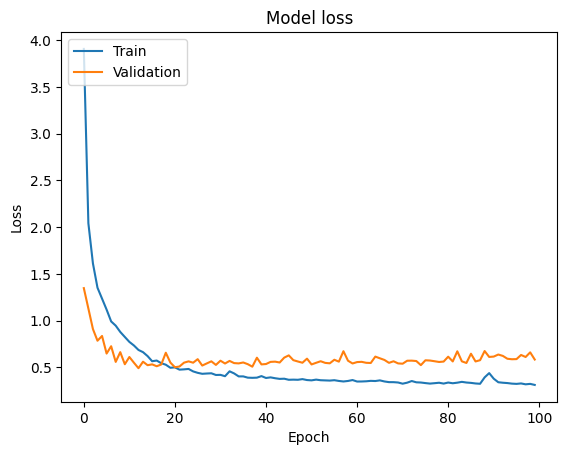

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Define new review data
new_reviews = [
    {'text': 'The flight was very comfortable and the staff were extremely friendly.', 'title': 'Great '},
    {'text': 'Attendants were the worst and the flight was also late', 'title': 'I will never travel in this flight again'}
]

# Preprocess the new review data
new_reviews_df = pd.DataFrame(new_reviews)
new_reviews_df['cleaned_text'] = new_reviews_df['text'].apply(preprocess_text)
new_reviews_df['cleaned_title'] = new_reviews_df['title'].apply(preprocess_text)

new_text_sequences = prepare_text(new_reviews_df, 'cleaned_text', tokenizer, max_length_text)
new_title_sequences = prepare_text(new_reviews_df, 'cleaned_title', tokenizer, max_length_title)

# Make predictions
predictions = model.predict({'text_input': new_text_sequences, 'title_input': new_title_sequences})
print(predictions)

1/1 [==============================] - 2s 2s/step
[[5.145838 ]
 [1.6227101]]


In [ ]:
# Define new review data
new_reviews = [
    {'text': 'The airplane was ok', 'title': 'Forgetfull Flight'}
]

# Preprocess the new review data
new_reviews_df = pd.DataFrame(new_reviews)
new_reviews_df['cleaned_text'] = new_reviews_df['text'].apply(preprocess_text)
new_reviews_df['cleaned_title'] = new_reviews_df['title'].apply(preprocess_text)

new_text_sequences = prepare_text(new_reviews_df, 'cleaned_text', tokenizer, max_length_text)
new_title_sequences = prepare_text(new_reviews_df, 'cleaned_title', tokenizer, max_length_title)

# Make predictions
predictions = model.predict({'text_input': new_text_sequences, 'title_input': new_title_sequences})
print(predictions)

1/1 [==============================] - 0s 25ms/step
[[3.4369547]]
